In [1]:
#Cargar Librerías
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import csv
%matplotlib inline
#plt.rcParams['figure.figsize'] = (16, 9)
#plt.style.use('fast')

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

In [2]:
#SACAR R2 ENTRE VALOR PREDIJO (EL MAS CERCANO, EL MÍNIMO) VS REAL
#AGREGAR VARIABLE "MARCA" AGRUPANDO CON LOS MÁS SIGINFICATIVOS Y "OTROS"

In [3]:
#Cargar archivo .CSV con datos de delitos
#Si es necesario, aún no se puede agregar más variables

df = pd.read_csv("/Users/j.artigasalegra/Documents/tesis/Solicitud_Base_Datos/Base_Dato_Con_Coorednadas/DATOS GEOCODIFICADOS/DATOS_2014_RED.csv",  parse_dates=[0], index_col=0, names=['Delito', 'DiaSem', 'Mes', 'Hora', 'TipoV', 'Longitud', 'Latitud'])
df.head(10)

,DiaSem,Mes,Hora,TipoV,Longitud,Latitud
Delito,,,,,,
1,3,1,1,2,-71.364279,-33.066009
2,3,1,4,1,-71.449283,-32.506328
3,3,1,5,1,-71.244152,-32.885247
4,3,1,5,4,-71.544414,-32.958467
5,3,1,6,1,-71.607311,-33.564088
6,3,1,8,1,-71.546929,-33.022157
7,3,1,9,3,-71.586060,-33.033630
8,3,1,11,5,-71.334306,-33.152032
9,3,1,13,1,-71.578250,-33.030275


In [4]:
df.describe()

,DiaSem,Mes,Hora,TipoV,Longitud,Latitud
count,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000
mean,3.956557,6.169262,12.381148,2.061885,-71.612225,-32.998425
std,1.972483,3.378725,7.380413,1.604838,2.668238,0.460287
min,1.000000,1.000000,0.000000,1.000000,-109.436278,-33.921019
25%,2.000000,3.000000,6.000000,1.000000,-71.559836,-33.049016
50%,4.000000,6.000000,12.000000,1.000000,-71.518119,-33.028333
75%,6.000000,9.000000,20.000000,3.000000,-71.395749,-32.975777
max,7.000000,12.000000,23.000000,6.000000,-70.182509,-27.073739


In [5]:
# convertir series a aprendizaje supervizado
#Aprendizaje supervisado será utilizando los 15 días previos para predecir el actual delito (latitud y longitud)

def series_to_supervised(data, n_in=1, n_out=2, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
PASOS = 15

data = df.values
data = data.astype('float32')
scaler = MinMaxScaler()
data = scaler.fit_transform(data[:, :6])
data = pd.DataFrame(data)
data.columns = data.columns
data=data.rename(columns = {0:'Diasem', 1:'Mes', 2:'Hora', 3:'TipoV', 4:'Longitud', 5:'Latitud'})
data.head()

scaledMerge= data

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
print(reframed.shape)
reframed.head()

(2425, 96)


,var1(t-15),var2(t-15),var3(t-15),var4(t-15),var5(t-15),var6(t-15),var1(t-14),var2(t-14),var3(t-14),var4(t-14),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
15,0.333333,0.0,0.043478,0.2,0.969894,0.124869,0.333333,0.0,0.173913,0.0,...,0.434783,0.0,0.964846,0.131588,0.666667,0.0,0.782609,0.0,0.965257,0.144309
16,0.333333,0.0,0.173913,0.0,0.967729,0.206606,0.333333,0.0,0.217391,0.0,...,0.782609,0.0,0.965257,0.144309,0.666667,0.0,0.782609,0.0,0.972954,0.151268
17,0.333333,0.0,0.217391,0.0,0.972954,0.151268,0.333333,0.0,0.217391,0.6,...,0.782609,0.0,0.972954,0.151268,0.666667,0.0,0.913043,0.0,0.965098,0.132321
18,0.333333,0.0,0.217391,0.6,0.965305,0.140575,0.333333,0.0,0.260870,0.0,...,0.913043,0.0,0.965098,0.132321,0.666667,0.0,0.956522,0.0,0.963761,0.053650
19,0.333333,0.0,0.260870,0.0,0.963703,0.052128,0.333333,0.0,0.347826,0.0,...,0.956522,0.0,0.963761,0.053650,0.666667,0.0,0.956522,1.0,0.967033,0.134938


In [7]:
#Se elimina las otras variables en perido t para solo tener como salida Longitud y Latitud

newReframed=reframed.drop(columns=['var1(t)','var2(t)','var3(t)','var4(t)'])
print(newReframed.shape)
newReframed.head()

(2425, 92)


,var1(t-15),var2(t-15),var3(t-15),var4(t-15),var5(t-15),var6(t-15),var1(t-14),var2(t-14),var3(t-14),var4(t-14),...,var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var5(t),var6(t)
15,0.333333,0.0,0.043478,0.2,0.969894,0.124869,0.333333,0.0,0.173913,0.0,...,0.965555,0.137534,0.666667,0.0,0.434783,0.0,0.964846,0.131588,0.965257,0.144309
16,0.333333,0.0,0.173913,0.0,0.967729,0.206606,0.333333,0.0,0.217391,0.0,...,0.964846,0.131588,0.666667,0.0,0.782609,0.0,0.965257,0.144309,0.972954,0.151268
17,0.333333,0.0,0.217391,0.0,0.972954,0.151268,0.333333,0.0,0.217391,0.6,...,0.965257,0.144309,0.666667,0.0,0.782609,0.0,0.972954,0.151268,0.965098,0.132321
18,0.333333,0.0,0.217391,0.6,0.965305,0.140575,0.333333,0.0,0.260870,0.0,...,0.972954,0.151268,0.666667,0.0,0.913043,0.0,0.965098,0.132321,0.963761,0.053650
19,0.333333,0.0,0.260870,0.0,0.963703,0.052128,0.333333,0.0,0.347826,0.0,...,0.965098,0.132321,0.666667,0.0,0.956522,0.0,0.963761,0.053650,0.967033,0.134938


In [8]:
#Separar datos como datos de entrenamiento y datos de prueba 
#Separa los datos en 70% (1700) train y 30% (725) validación

values = newReframed.values
train = values[0:1700, :]
test = values[1700:2426, :]

# split into input and outputs

x_train, y_train = train[:, 0:90], train[:, 90:97]
x_val, y_val = test[:, 0:90], test[:, 90:97]

# reshape input to be 3D [samples, timesteps, features]
#x_train = x_train.reshape((x_train.shape[0], 1,x_train.shape[1]))
#x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(1700, 90) (1700, 2) (725, 90) (725, 2)


In [9]:
#Se define la red neuronal, cuando tenga la red lista, probare con distintas funciones de activación o nodos

def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(90, input_dim=(90), kernel_initializer='normal',activation='tanh'))
    model.add(Dense(2, kernel_initializer='normal', activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [10]:
#Despues de tener lista la red, variare EPOCHS para ver como mejoran los resultados
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 90)                8190      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 182       
Total params: 8,372
Trainable params: 8,372
Non-trainable params: 0
_________________________________________________________________
Train on 1700 samples, validate on 725 samples
Epoch 1/40
1700/1700 [==============================] - 4s 2ms/sample - loss: 0.0279 - mse: 0.0052 - val_loss: 0.0193 - val_mse: 0.0074
Epoch 2/40
1700/1700 [==============================] - 3s 2ms/sample - loss: 0.0185 - mse: 0.0037 - val_loss: 0.0193 - val_mse: 0.0073
Epoch 3/40
1700/1700 [==============================] - 2s 1ms/sample - loss: 0.0176 - mse: 0.0036 - val_loss: 0.0191 - val_mse: 0.0074
Epoch 4/40
1700/1700 [==============================] - 2s 1m

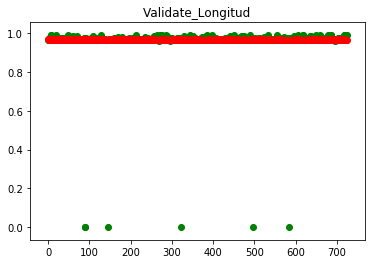

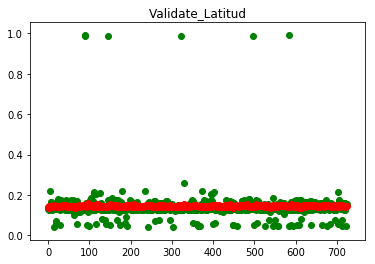

In [11]:
#Renombrar columnas de variable predicha y validación

results=model.predict(x_val)
results = pd.DataFrame(results)
results.columns = results.columns
results=results.rename(columns = {0:'Longitud', 1:'Latitud'})
#print(results)

y_val = pd.DataFrame(y_val)
y_val.columns = y_val.columns
y_val=y_val.rename(columns = {0:'Longitud', 1:'Latitud'})
#print(y_val)

#Permite visualizar que tanto se acerca la predicción con los valores de validación
plt.scatter(range(len(y_val['Longitud'])),y_val['Longitud'],c='g')
plt.scatter(range(len(results['Longitud'])),results['Longitud'],c='r')
plt.title('Validate_Longitud')
plt.show()

plt.scatter(range(len(y_val['Latitud'])),y_val['Latitud'],c='g')
plt.scatter(range(len(results['Latitud'])),results['Latitud'],c='r')
plt.title('Validate_Latitud')
plt.show()

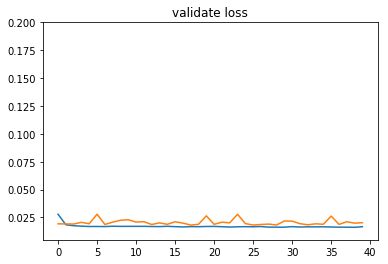

In [12]:
#Permite graficar la pérdida LOSS tanto del conjunto de ENTENAMIENTO(azul)  como de VALIDACION(naranja)

plt.ylim(0.005, 0.2)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

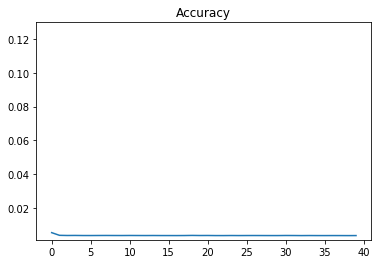

In [13]:
plt.ylim(0.001, 0.13)
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [14]:
#Agregar 4 columnas falsasa para poder invertir valores a original

results['Var3'] = results['Longitud']
results['Var4'] = results['Longitud']
results['Var5'] = results['Longitud']
results['Var6'] = results['Latitud']
print(results)

y_val['Var3'] = y_val["Latitud"]
y_val['Var4'] = y_val["Latitud"]
y_val['Var5'] = y_val["Longitud"]
y_val['Var6'] = y_val["Latitud"]
print(y_val)

     Longitud   Latitud      Var3      Var4      Var5      Var6
0    0.968042  0.140941  0.968042  0.968042  0.968042  0.140941
1    0.967490  0.142133  0.967490  0.967490  0.967490  0.142133
2    0.968251  0.145392  0.968251  0.968251  0.968251  0.145392
3    0.965591  0.135921  0.965591  0.965591  0.965591  0.135921
4    0.965532  0.141850  0.965532  0.965532  0.965532  0.141850
5    0.963611  0.142817  0.963611  0.963611  0.963611  0.142817
6    0.966853  0.145484  0.966853  0.966853  0.966853  0.145484
7    0.966100  0.141620  0.966100  0.966100  0.966100  0.141620
8    0.964970  0.140848  0.964970  0.964970  0.964970  0.140848
9    0.966778  0.143231  0.966778  0.966778  0.966778  0.143231
10   0.967314  0.139734  0.967314  0.967314  0.967314  0.139734
11   0.965125  0.139951  0.965125  0.965125  0.965125  0.139951
12   0.965701  0.141359  0.965701  0.965701  0.965701  0.141359
13   0.967068  0.147752  0.967068  0.967068  0.967068  0.147752
14   0.963963  0.137817  0.963963  0.963

In [15]:
#Primero se inviernten los valores de "y_val" y "results" a su valor original
inverted_res = scaler.inverse_transform(results.values)
compara_res = pd.DataFrame(inverted_res)

inverted_y_val = scaler.inverse_transform(y_val.values)
compara_y_val = pd.DataFrame(inverted_y_val)

#Segundo se asgina nombre a las columnas de cada variable
compara_y_val=compara_y_val.rename(columns = {0:'Falso1', 1:'Falso2', 2:'Falso3', 3:'Falso4', 4:'Longitud', 5:'Latitud'})
compara_res=compara_res.rename(columns = {0:'Falso1', 1:'Falso2', 2:'Falso3', 3:'Falso4', 4:'Longitud', 5:'Latitud'})

#Tercero se eliminan las variables no necesarias
compara_res = compara_res.drop(['Falso1', 'Falso2', 'Falso3', 'Falso4'], axis=1)
compara_y_val = compara_y_val.drop(['Falso1', 'Falso2', 'Falso3', 'Falso4'], axis=1)
#print(compara_y_val)
#print(compara_res)

#Cuarto crea variable "diferencia" entre valores de resultado y validación, tanto para longitud como latitud
diferencia_lon = compara_res['Longitud'] - compara_y_val['Longitud']
diferencia_lat  = compara_res['Latitud'] - compara_y_val['Latitud']
print(diferencia_lon)
print(diferencia_lat)

0      0.130417
1     -0.020073
2      0.107452
3     -0.051529
4      0.001976
5     -0.543152
6     -0.831718
7     -0.861290
8     -0.015915
9     -0.793846
10    -0.043213
11     0.052010
12     0.039566
13    -0.210419
14    -0.169182
15     0.136757
16    -0.008026
17     0.022507
18     0.090591
19     0.191971
20    -0.930420
21     0.017838
22    -0.022652
23    -0.322823
24    -0.213127
25     0.044205
26     0.035133
27    -0.142395
28     0.087395
29     0.104355
         ...   
695    0.157700
696    0.043251
697    0.147163
698    0.021614
699    0.005531
700   -0.059006
701   -0.071175
702   -0.112816
703    0.047050
704   -0.194763
705   -0.027664
706   -0.344124
707   -0.009911
708   -0.303566
709   -0.035683
710   -0.081306
711   -0.062576
712    0.080467
713    0.043053
714   -0.123154
715    0.021568
716    0.065681
717   -0.004494
718   -0.965782
719   -0.965294
720   -0.296890
721   -0.379845
722   -0.345741
723    0.065254
724   -0.927315
Name: Longitud, Length: 

In [16]:
#Compara Longitudes reales, predichos y su diferencia.
compara_lon = pd.DataFrame(np.array([compara_y_val['Longitud'], compara_res['Longitud']])).transpose()
compara_lon.columns = ['real', 'prediccion']

compara_lon2 = pd.DataFrame(compara_lon)
compara_lon2.columns = ['real', 'prediccion']
compara_lon2['diferencia'] = diferencia_lon
compara_lon2.head(4)

,real,prediccion,diferencia
0,-71.567383,-71.436966,0.130417
1,-71.438568,-71.458641,-0.020073
2,-71.536247,-71.428795,0.107452
3,-71.481674,-71.533203,-0.051529


In [17]:
#Compara Latitudes reales, predichos y su diferencia.
compara_lat = pd.DataFrame(np.array([compara_y_val['Latitud'], compara_res['Latitud']])).transpose()
compara_lat.columns = ['real', 'prediccion']

compara_lat2 = pd.DataFrame(compara_lat)
compara_lat2.columns = ['real', 'prediccion']
compara_lat2['diferencia'] = diferencia_lat
compara_lat2.head(4)

,real,prediccion,diferencia
0,-33.030678,-32.955959,0.074718
1,-33.054306,-32.947796,0.106510
2,-32.980659,-32.925480,0.055180
3,-33.030792,-32.990330,0.040462


In [21]:
#Descarga archivo .CSV con predicción de longitud y latitud

prediccion_lon = pd.DataFrame(compara_lon2)
prediccion_lon.to_csv('pronostico_longitud.csv')

In [22]:
#Descarga archivo .CSV con predicción de longitud y latitud

prediccion_lat = pd.DataFrame(compara_lat2)
prediccion_lat.to_csv('pronostico_latitud.csv')

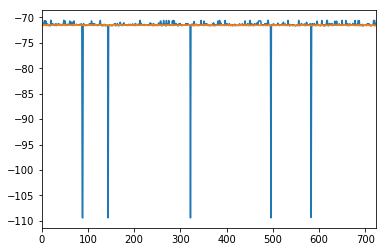

In [19]:
#Gráfico de los resultados de la predicción versus los datos reales
#de variable "Longitud del delito"

compara_lon['real'].plot() #Color azul
compara_lon['prediccion'].plot() #Color naranjo

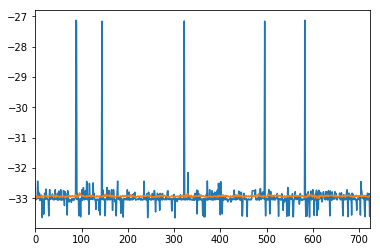

In [20]:
#Gráfico de los resultados de la predicción versus los datos reales
#de variable "Latitud del delito"

compara_lat['real'].plot() #Color azul
compara_lat['prediccion'].plot() #Color naranjo